In [53]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 확인

In [54]:
# 데이터 로드
df = pd.read_csv('./spam.csv')
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


# 토큰화

토크나이저: NLTK의 WordPunctTokenizer는 구두점을 별도의 토큰으로 분리하므로, 스팸 메시지에서 자주 사용되는 특수 문자를 캡처할 수 있다.

In [55]:
# 토크나이징
tokenizer = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'[^a-z0-9]', ' ', text)
    # 토크나이징
    tokens = tokenizer.tokenize(text)
    # 불용어 제거
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

df['tokens'] = df['v2'].apply(preprocess_text)
df.head(3)

,v1,v2,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."


# 임베딩

임베딩: Word2Vec의 CBOW 모델은 주변 단어(context word)로부터 중심 단어(Center Word)를 예측하는 방식으로 작동하므로, 단어의 문맥을 잘 파악할 수 있다. 스팸 메시지는 종종 일반적인 단어를 악용하여 스팸 필터를 우회하려고 시도하기 때문에, 문맥 정보를 파악하는 CBOW를 사용한다.

In [56]:
# 임베딩
model = Word2Vec(df['tokens'], min_count=1, vector_size=50, window=5, sg=0)  # sg:0 -> CBOW 모델 사용

# 임베딩 결과 확인
example_word = df['tokens'][0][0]  # 첫 번째 메시지의 첫 번째 단어
print(f"{example_word} 단어의 벡터: {model.wv[example_word]}")  # 첫 번째 단어의 벡터 출력

go 단어의 벡터: [ 0.11147688 -0.05661742 -0.16576049  0.38149998 -0.16992843 -0.67328197
  0.88304025  1.1715106  -1.4367069  -0.6725803  -0.24348126 -1.2241918
  0.08001899  0.4615427  -0.6940653   0.21596847  0.53610766 -0.12423749
 -1.3431425  -0.67163765  0.3125737   0.69944113  1.2298963  -0.6175287
  0.82411945  0.51520514 -0.48978448 -0.2480604  -1.1934315   0.5730875
  0.39184698 -0.5329835  -0.31015918  0.05365003 -0.5127042   0.7601223
  0.3543752   0.5584408   0.48089367 -0.74854445  0.93480885 -0.26394042
 -0.07323258  0.42421195  1.7585852   0.24941507 -0.40093693 -0.9365553
  0.59029055  0.505542  ]


# 결과 해석
1. WordCloud: 텍스트 데이터에서 가장 빈번하게 등장하는 단어를 시각화

In [43]:
pip install wordcloud

     -------------------------------------- 300.6/300.6 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


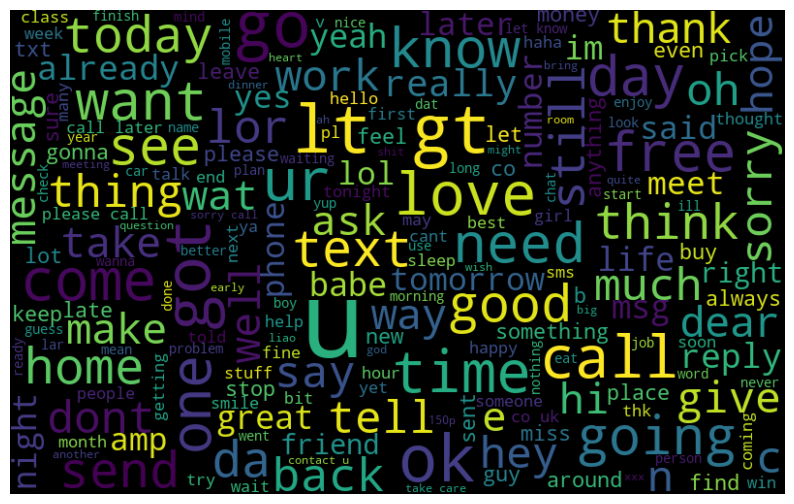

In [57]:
# Wordcloud 생성
all_words = [word for tokens in df['tokens'] for word in tokens]
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

2. 스팸 분류

In [58]:
# 이진 분류 모델 학습
df['spam'] = df['v1'].map({'spam': 1, 'ham': 0})
X_train, X_test, y_train, y_test = train_test_split(df['v2'], df['spam'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

# 모델 성능 확인
print(f"테스트 세트 정확도: {model.score(X_test_vec, y_test)}")

테스트 세트 정확도: 0.9659192825112107


3. 유사도 (예시 단어: money)

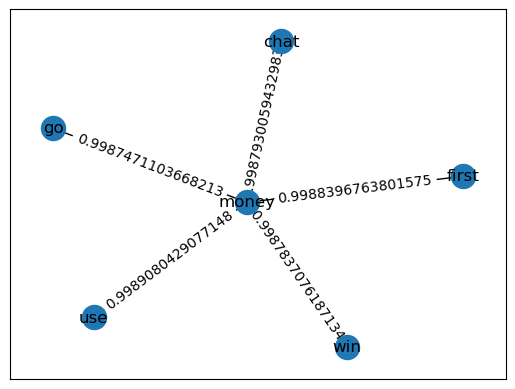

In [59]:
# 그래프 생성
G = nx.Graph()

# 'money'와 유사한 단어를 노드로 추가
for word, similarity in similar_words:
    G.add_edge('money', word, weight=similarity)

# 그래프 그리기
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()